# Testing new synthesis methods

In [2]:
import plenoptic as po
import torch
import matplotlib.pyplot as plt
import pytest
from torchvision.models import vgg16
%matplotlib inline
%load_ext autoreload
%autoreload 2

To get started, let's load an example image.

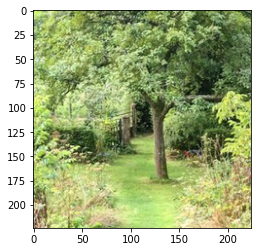

In [3]:

im = po.tools.load_images('../data/frontwindow.jpeg', as_gray=False)
im = im[...,300:524,300:524]
plt.imshow(im.squeeze().permute(1,2,0))


Now we will compare metamer synthesis for two models: Two different layers (pool1) and (pool2) from the VGG16 model. The initialization of these models is shown below. 

In [18]:
from torch import nn
model_vgg = vgg16(pretrained=True).eval()
model_pool1 = nn.Sequential(*list(model_vgg.children())[0][0:5])
model_pool2 = nn.Sequential(*list(model_vgg.children())[0][0:10])
synth_1 = po.synthesize.SimpleMetamer(im,model_pool1)
synth_2 = po.synthesize.SimpleMetamer(im, model_pool2)

In [19]:
synths =[synth_1, synth_2]
final_images = []
for synth in synths:
	# we do have a default optimizer, with a specific lr and other parameters -- 
	# if you want other than the default, create one and pass it to `synthesize`
	optim = torch.optim.Adam([synth.synthesized_signal], lr=.005)
	s = synth.synthesize(optimizer=optim, max_iter=20)
	# if we call synthesize again, resume where we left off. 
	# If you don't pass an optimizer object, we re-use the old one.
	s = synth.synthesize(max_iter=400)
	final_images.append(s.squeeze().permute(1,2,0).detach())


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Let's look at the losses over time for both model synthesis runs!

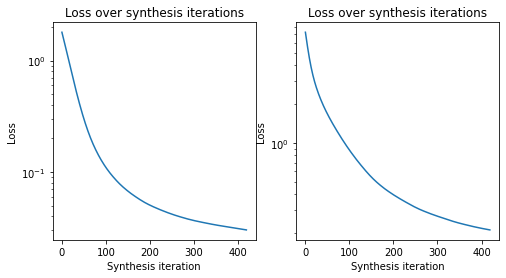

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
	ax[i].semilogy(synths[i].losses)
	ax[i].set(title="Loss over synthesis iterations", ylabel="Loss", xlabel="Synthesis iteration");

The left column below shows the target image and the following two images are the synthesized images for the pool1 and pool2 layers out of the VGG16 network.
We can see that, even though the target and synthesized images look *very* different, the difference between the representations (MSE loss between the representation of the synthesized images vs the target) is very small (see above).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


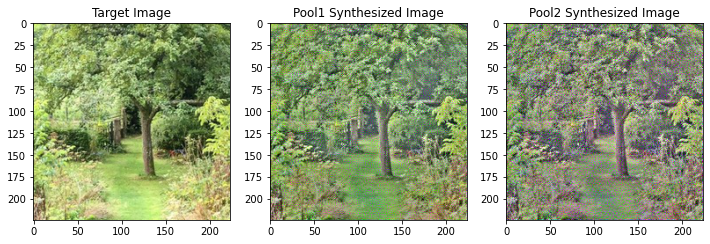

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
titles =["Target Image", "Pool1 Synthesized Image", "Pool2 Synthesized Image"] 
for i in range(3):
        if i == 0:
                ax[0].imshow(im.squeeze().permute(1,2,0))
                ax[0].set(title=titles[0])
        else:
                ax[i].imshow(final_images[i-1])
                ax[i].set(title=titles[i])


We also provide the methods `.to`, `.save`, and `.load`.

`.to` and `.save` work as you'd expect (`.to` works in place):

In [22]:
synth_1.save('pool1_synth.pt')

Because the models used in synthesis can be quite large and do not change during synthesis, we do not save them. Therefore, `.load` is an instance method: it must be called by an instance of the object, like so:

In [23]:
synth_1_reload = po.synthesize.SimpleMetamer(im, model_pool1)
print(torch.allclose(synth_1_reload.synthesized_signal, synth_1.synthesized_signal, atol=1e-2))
synth_1_reload.load('pool1_synth.pt')
print(torch.allclose(synth_1_reload.synthesized_signal, synth_1.synthesized_signal, atol=1e-2))

False
True


Because of this, we want to make sure the two versions were initialized in the same way; if you initialize `SimpleMetamer` with a different model or a different target image, it will raise an exception (in both cases, we catch this because `target_model_responses` is different, which is easier than checking whether the specific model is different):

In [24]:
synth_rand = po.synthesize.SimpleMetamer(torch.rand_like(im), model_pool1)
try:
    synth_rand.load('pool1_synth.pt')
except Exception as e:
    print(f'Exception: {e}')

Exception: Saved and initialized target_model_response are different! Initialized: tensor([[[[8.0899e-01, 0.0000e+00, 7.2933e-01,  ..., 1.2785e+00,
           9.6010e-02, 0.0000e+00],
          [9.8922e-01, 1.8404e+00, 1.7007e+00,  ..., 1.3113e+00,
           9.8623e-01, 2.4355e-01],
          [1.2283e+00, 3.8982e-01, 1.7707e+00,  ..., 1.2077e+00,
           0.0000e+00, 7.9545e-01],
          ...,
          [2.5950e+00, 3.0736e-01, 1.2727e+00,  ..., 1.1301e+00,
           2.2394e+00, 2.4195e+00],
          [1.3835e+00, 0.0000e+00, 4.5129e-01,  ..., 9.3155e-01,
           0.0000e+00, 1.7435e+00],
          [2.6879e+00, 8.8349e-01, 1.0283e+00,  ..., 4.7863e-01,
           6.5750e-01, 1.0827e+00]],

         [[1.1253e+00, 3.1096e-01, 9.9570e-01,  ..., 9.3236e-01,
           1.7978e+00, 0.0000e+00],
          [2.3266e+00, 9.6605e-01, 7.4483e-01,  ..., 5.2815e-01,
           5.4962e-01, 1.8218e-01],
          [1.4909e+00, 4.4529e-01, 0.0000e+00,  ..., 2.4497e-01,
           5.3720e-01, 1.40